# Exploratory Data Analysis and Visualization

This notebook performs exploratory data analysis (EDA) and visualization on NYC taxi trip data. Key steps include:

1. **Initialization**: Setting up a Spark session and loading the necessary libraries and data.
2. **Correlation Analysis**: Generating a correlation heatmap to explore relationships between numerical variables.
3. **Distribution Analysis**: Visualizing the distributions of key variables like fare amount, trip distance, and trip duration.
4. **Temporal Patterns**: Analyzing how fare amounts and trip counts vary by hour of the day, day of the week, and over time.
5. **Geospatial Analysis**: Mapping average fares, trip densities, and peak hours by pickup and drop-off locations across NYC taxi zones.
6. **Saving Outputs**: Saving all plots to the specified directory for future reference.

## Libraries and Initial Setup

We start by importing the necessary libraries and initializing a Spark session.

In [8]:
from pyspark.sql import SparkSession
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
# Initialize Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/08/25 22:16:29 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.11.182 instead (on interface en0)
24/08/25 22:16:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 22:16:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# Ensure the 'plots' directory exists
output_dir = '../plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Load and Inspect Data

We load the cleaned taxi data from a Parquet file into a Pandas DataFrame for easier manipulation and visualization. Additionally, we inspect the data types of the columns to ensure everything is correctly loaded.

In [3]:
# Load the cleaned taxi data from a Parquet file
df = pd.read_parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/curated3')

In [4]:
# Display the data types of each column to verify correct loading
df.dtypes

VendorID                                  int32
tpep_pickup_datetime             datetime64[ns]
tpep_dropoff_datetime            datetime64[ns]
passenger_count                         float64
trip_distance                           float64
RatecodeID                              float64
store_and_fwd_flag                        int32
PULocationID                              int32
DOLocationID                              int32
payment_type                              int64
fare_amount                             float64
extra                                   float64
mta_tax                                 float64
tip_amount                              float64
tolls_amount                            float64
improvement_surcharge                   float64
total_amount                            float64
congestion_surcharge                    float64
airport_fee                             float64
trip_duration_mins                      float64
pickup_hour                             

### Data Type Conversion

Convert the `precipitation` column to a float data type to ensure it's in the correct format for analysis. The Dataset shape stays the same at this step

In [5]:
# Convert 'precipitation' column to float for accurate numerical analysis
df['precipitation'] = df['precipitation'].astype('float64')

### Data Sampling

We sample 0.2% of the data for certain visualizations to make plotting faster and more efficient without compromising the analysis.

In [6]:
# Sample 0.2% of the data for visualization when needed
df_sample = df.sample(frac=0.002, random_state=1003)

## Correlation Analysis

We calculate the correlation matrix to explore relationships between numerical variables in the dataset. We specifically highlight correlations above 0.7 or below -0.7 in a heatmap to see any noticable strong relationships.

In [12]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = df.corr()

# Create a mask to highlight strong correlations (absolute value > 0.7)
mask = (correlation_matrix > 0.7) | (correlation_matrix < -0.7)
annot = np.where(mask, correlation_matrix.round(2).astype(str), "")

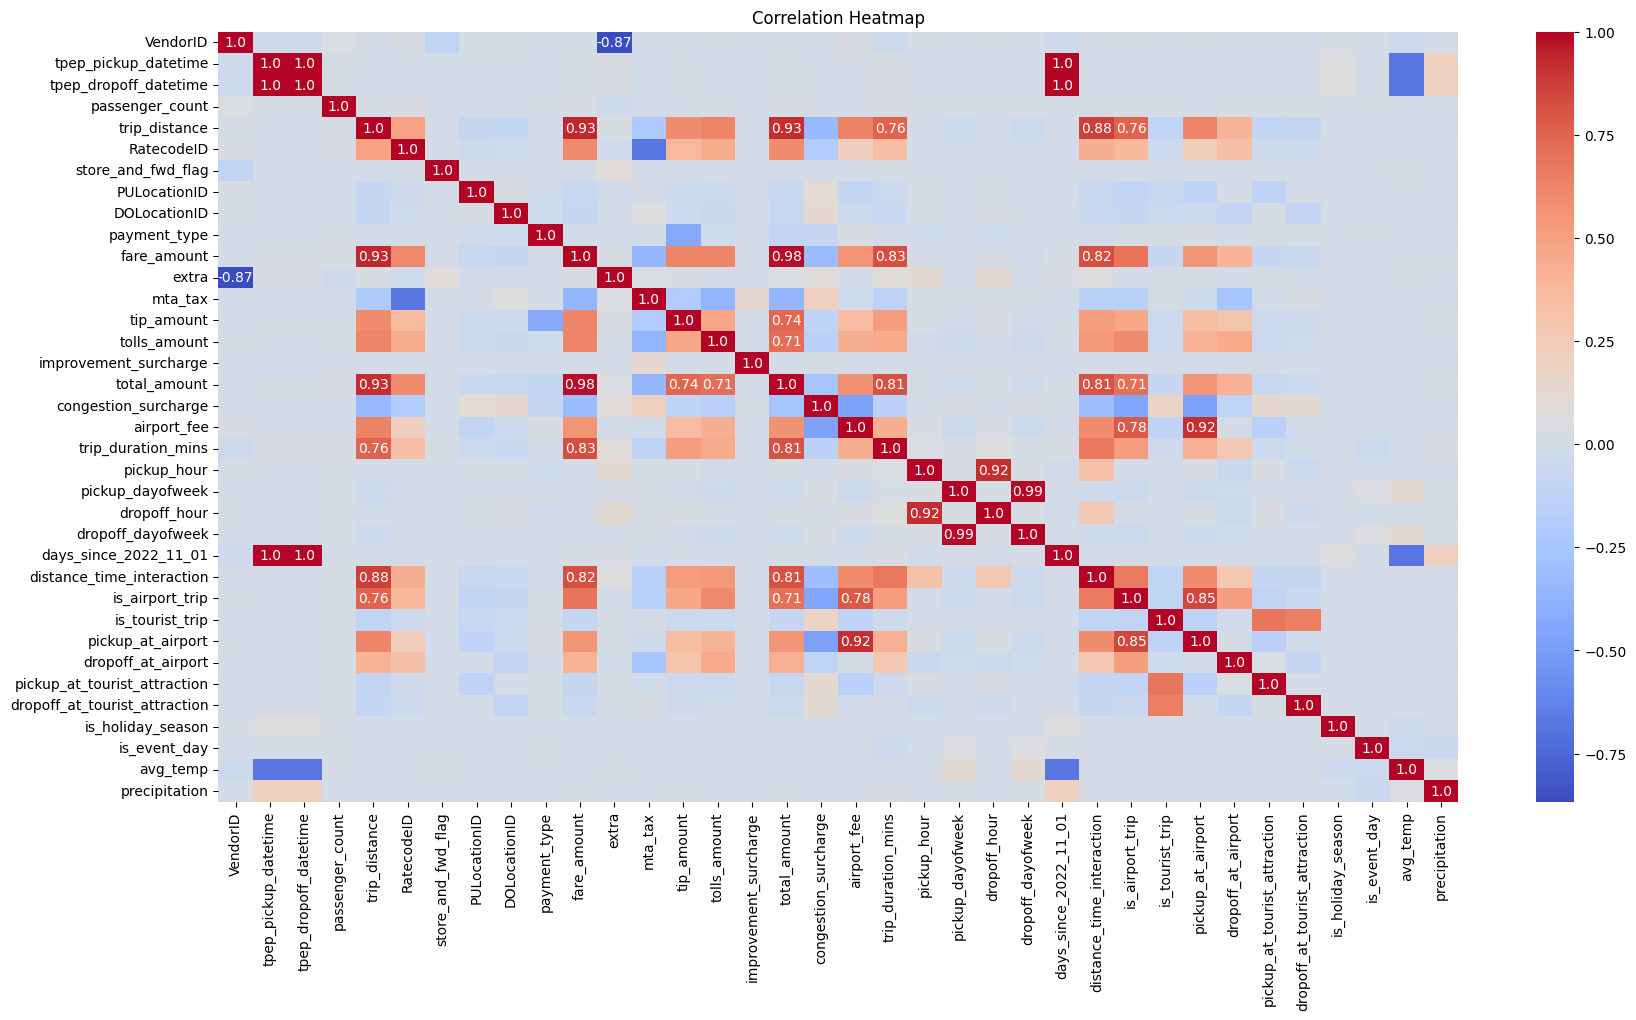

In [15]:
# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', fmt='s')
plt.title('Correlation Heatmap')

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

### Correlation Heatmap Analysis

This correlation heatmap visualizes the relationships between different variables in the dataset, where:

- **Strong Positive Correlations**:
  - **fare_amount** is highly correlated with **trip_duration_mins** (0.83), **trip_+distance** (0.93) and **distance_time_interaction** (0.82). This is expected as fare amount typically constitutes a significant portion of the total amount, and tolls directly contribute to it.
  - **trip_duration_mins** shows strong correlations with **trip_distance** (0.76), indicating that trip length is closely related to the time of day.
  - **pickup_at_airport** and **is_airport_trip** and **arport_fee** have sstrong correlations with each others, which is expected as they are all related to airport trips.

- **Strong Negative Correlations**:
  - **VendorID** has a strong negative correlation with **extra** (-0.87), suggesting that in cases where extra charges are applied, the fare amount might be relatively lower.

=> The heatmap highlights key relationships that can guide further analysis, such as the dependence of fare and total amounts on trip duration and distance. It also shows which variables are likely to be redundant due to high correlations, suggesting potential areas for feature reduction or further investigation. These relationships also indicate multicolinearity, which is importance when considering linear models.

## Distribution Analysis

We visualize the distribution of key variables such as `fare_amount`, `tip_amount`, `trip_duration_mins`, `trip_distance`, `avg_temp`, and `precipitation` to understand their spread and central tendency.

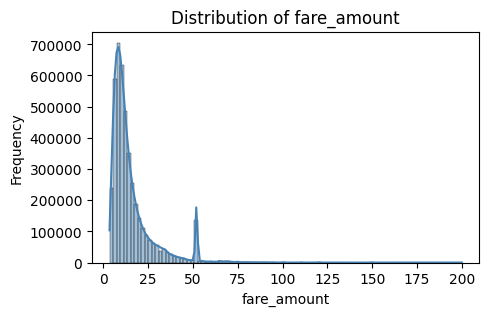

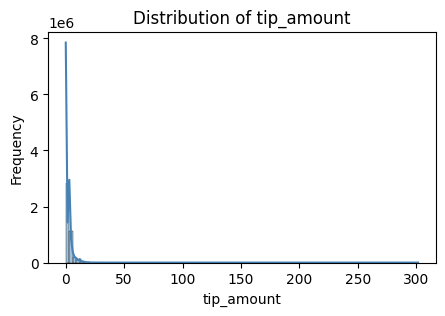

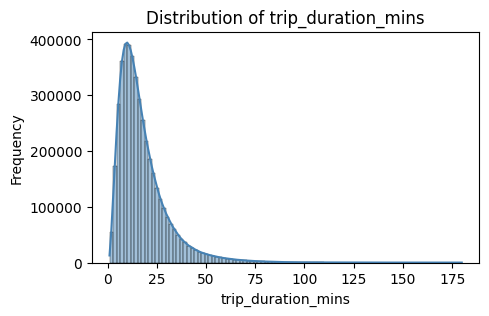

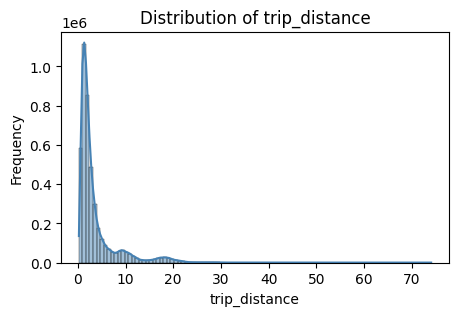

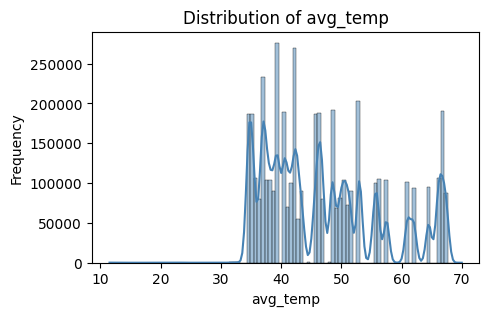

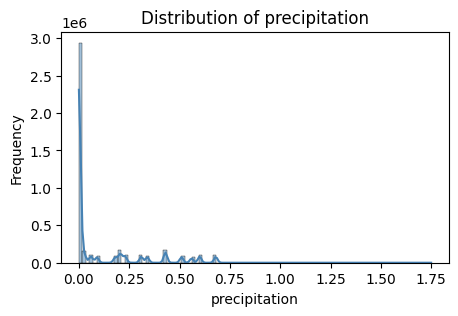

In [16]:
# Define a list of features to plot their distributions
features_to_plot = ['fare_amount', 'tip_amount', 'trip_duration_mins', 'trip_distance', 'avg_temp', 'precipitation']

# Plot histograms with KDE for each feature
for feature in features_to_plot:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[feature], bins=100, kde=True, color='steelblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    # Save the plot to the 'plots' directory
    plt.savefig(os.path.join(output_dir, f'{feature}_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

1. **Fare Amount**:
   - The distribution is heavily right-skewed, with most fares concentrated below $30.
   - There's a secondary peak around $50, possibly due to standard fare rates for specific routes, but the majority of fares fall below $25.

2. **Tip Amount**:
   - The distribution is extremely right-skewed, with most tips being close to $0.
   - There are very few instances of tips exceeding $50, suggesting that larger tips are rare.

3. **Trip Duration (minutes)**:
   - Most trips are relatively short, with the majority lasting under 25 minutes.
   - The distribution is right-skewed, indicating a few longer trips, but the bulk are quick trips.

4. **Trip Distance**:
   - The distribution is right-skewed, with most trips covering short distances, typically less than 5 miles.
   - Very few trips exceed 20 miles, reflecting typical urban taxi ride distances.

5. **Average Temperature**:
   - The distribution of `avg_temp` is more spread out, reflecting a wide range of temperatures.
   - There is a notable concentration of data points in the 30-60°F range, possibly reflecting a specific seasonal period in the data.

6. **Precipitation**:
   - The distribution is heavily right-skewed, with most days having little to no precipitation.
   - Days with more than 0.25 inches of precipitation are rare, indicating that significant rainfall events are uncommon in this dataset.

### Boxplot Analysis

We use boxplots to verify that the distribution of `trip_distance`, `fare_amount`, and `trip_duration_mins` are right-skewed.

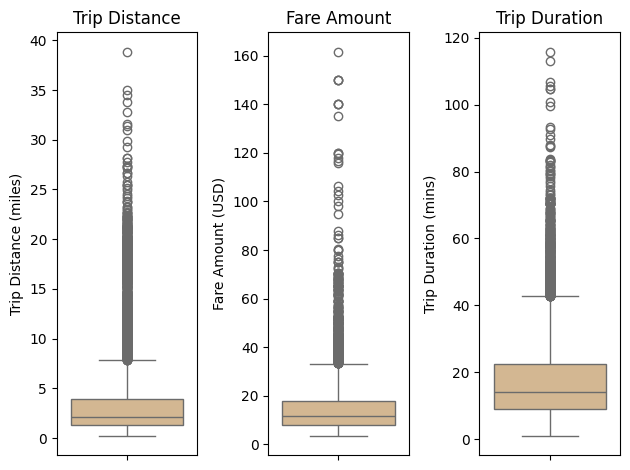

In [10]:
# Plot boxplots for trip distance, fare amount, and trip duration
plt.subplot(1, 3, 1)
sns.boxplot(y='trip_distance', data=df_sample, color='burlywood')
plt.title('Trip Distance')
plt.ylabel('Trip Distance (miles)')

plt.subplot(1, 3, 2)
sns.boxplot(y='fare_amount', data=df_sample, color='burlywood')
plt.title('Fare Amount')
plt.ylabel('Fare Amount (USD)')

plt.subplot(1, 3, 3)
sns.boxplot(y='trip_duration_mins', data=df_sample, color='burlywood')
plt.title('Trip Duration')
plt.ylabel('Trip Duration (mins)')

plt.tight_layout()
plt.show()

## Fare Amount by Day of the Week

This visualization examines how `fare_amount` varies by the day of the week using a boxplot, which helps in identifying trends or patterns related to specific days.

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_63846/3262026921.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pickup_dayofweek', y='fare_amount', data=df, palette='Set3')


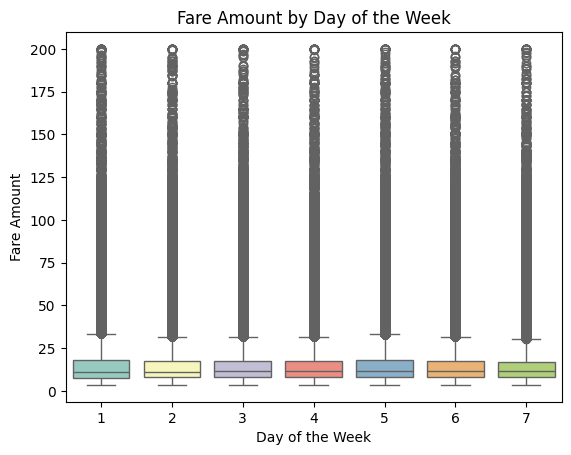

In [18]:
# Plot boxplot of fare amount by day of the week
sns.boxplot(x='pickup_dayofweek', y='fare_amount', data=df, palette='Set3')
plt.title('Fare Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fare Amount')
# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'fare_dayofweek.png'), dpi=300, bbox_inches='tight')
plt.show()

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_63846/3840540810.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pickup_dayofweek', y='fare_amount', data=df_sample, palette='Set3')


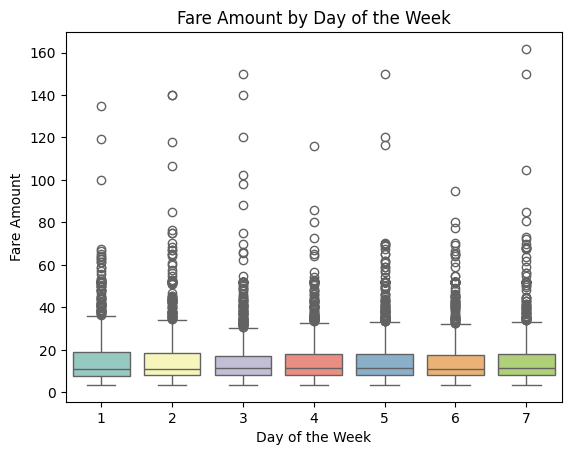

In [17]:
sns.boxplot(x='pickup_dayofweek', y='fare_amount', data=df_sample, palette='Set3')
plt.title('Fare Amount by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Fare Amount')
# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'fare_dayofweek_sampled.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Full Dataset vs. Sample**:
   - **Full Dataset**: The boxplot from the full dataset shows a large number of outliers, making it difficult to discern the central distribution of fare amounts. The plot is densely populated with individual points at the upper range, leading to visual clutter.
   - **Sampled Dataset**: In contrast, the boxplot generated from the sampled dataset is less cluttered, with fewer outliers, making the distribution of fare amounts more visible and interpretable. The sampling reduces the number of data points, improving clarity without sacrificing overall insights.

2. **Day-to-Day Comparison**:
   - Across all days of the week, the distribution of fare amounts remains fairly consistent, with median values clustered around similar levels.
   - Outliers exist for all days, with some fares reaching significantly higher values, although these are more manageable in the sampled data. All are highly right-skewed.

3. **Data Visualization Insight**:
   - **Importance of Sampling**: The comparison demonstrates the utility of sampling in data visualization, especially when dealing with large datasets. Sampling makes the data easier to visualize and interpret, reducing the visual noise caused by a high density of points.
   - **Outlier Impact**: The numerous outliers in the full dataset can obscure the central trend, while a sampled dataset helps in focusing on the main distribution without the distraction of excessive outlier points.

## Trip Count by Hour of the Day

We visualize the number of trips by the hour of the day using a count plot, which helps in understanding the peak hours for taxi rides.

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_63846/3266182663.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pickup_hour', data=df, palette='viridis')


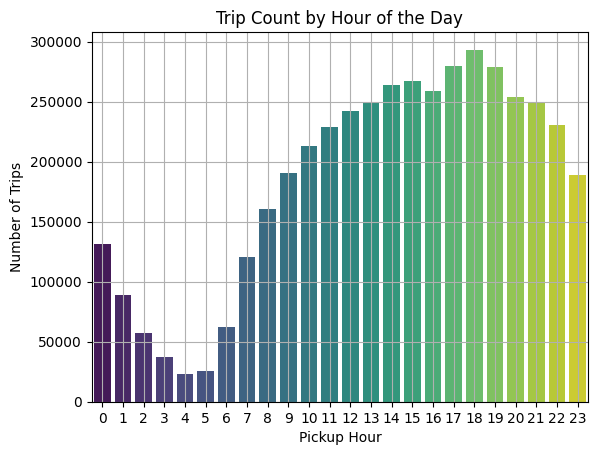

In [19]:
# Plot count of trips by hour of the day
sns.countplot(x='pickup_hour', data=df, palette='viridis')
plt.title('Trip Count by Hour of the Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.grid(True)
# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'tripcount_hourofday.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Peak Hours**:
   - The highest number of trips occurs between 17:00 (5 PM) and 19:00 (7 PM), with a peak around 18:00 (6 PM).
   - This suggests that the evening rush hour is the busiest period for taxi services, likely due to people commuting from work.

2. **Morning Build-Up**:
   - There's a gradual increase in trip counts starting from 6:00 AM, with a significant rise from 8:00 AM to 9:00 AM, indicating morning rush hour activity as people commute to work.

3. **Late Night Activity**:
   - Trip counts remain relatively high until around 22:00 (10 PM), after which there is a noticeable drop. The lowest number of trips occurs between 3:00 AM and 5:00 AM, reflecting the quiet hours when most people are likely asleep.

4. **Hourly Distribution**:
   - The data shows a clear diurnal pattern, with lower activity during early morning hours, a steady increase through the day, peaking in the late afternoon, and then gradually tapering off at night.

### Key Insights
- **Rush Hour Trends**: The sharp increase in trip counts during morning and evening rush hours suggests that taxi services are heavily utilized for commuting purposes.
- **Late Night**: Despite the drop in trips during the late night, there is still significant activity up until around midnight, which could be driven by nightlife or late commutes.

## Average Fare by Day

We analyze the daily average fare amount over time and apply a smoothing function to highlight long-term trends and seasonality.

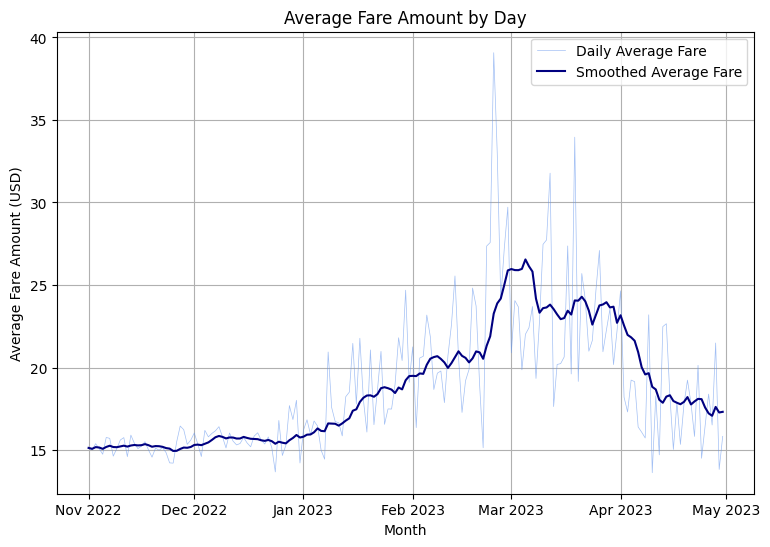

In [20]:
# Calculate daily average fare and apply smoothing
daily_fare = df.groupby('days_since_2022_11_01')['fare_amount'].mean().reset_index()
start_date = pd.to_datetime('2022-11-01')
daily_fare['date'] = start_date + pd.to_timedelta(daily_fare['days_since_2022_11_01'], unit='D')

# Apply rolling mean for smoothing
daily_fare['smoothed_fare'] = daily_fare['fare_amount'].rolling(window=12, min_periods=1).mean()

# Plot daily and smoothed average fare amounts
plt.figure(figsize=(9, 6))
plt.plot(daily_fare['date'], daily_fare['fare_amount'], color='cornflowerblue', linewidth=0.5, alpha=0.6, label='Daily Average Fare')
plt.plot(daily_fare['date'], daily_fare['smoothed_fare'], color='navy', linewidth=1.5, label='Smoothed Average Fare')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

plt.title('Average Fare Amount by Day')
plt.xlabel('Month')
plt.ylabel('Average Fare Amount (USD)')
plt.grid(True)
plt.legend()

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'meanfare_overtime.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Fare Trends**:
   - The chart shows the daily average fare amount in USD from November 2022 to May 2023, with a clear upward trend starting in January and peaking in March 2023.
   - This trend can help tourists plan their budget for transportation more effectively, especially if visiting during peak periods.

2. **Peak Season Consideration**:
   - The highest average fares occurred in March 2023, possibly due to a peak tourist season, holidays, and special events.
   - Tourists visiting during this time might expect to pay higher fares for taxi services, so it's advisable to plan accordingly.

3. **Off-Peak Travel Advantage**:
   - Fares are lower in the months of November 2022 to January 2023, and again from April to May 2023.
   - Traveling during these off-peak times could help tourists save on transportation costs, as fare amounts are more stable and lower compared to the peak period in March.

4. **Daily Variability**:
   - While the smoothed trend provides a general idea, daily fare amounts can still fluctuate significantly, especially during peak periods.
   - Tourists should be prepared for potential variations in fare prices depending on specific days, possibly influenced by weather, local events, or demand surges.

### Key Insights
- **Plan Around Peak Seasons**: If you are traveling during peak times like March, be aware of potentially higher transportation costs.
- **Consider Off-Peak Travel**: Visiting during off-peak times, such as late fall or early spring, could result in lower taxi fares, leaving more room in the budget for other activities.
- **Be Flexible**: Even within a trip, being flexible with your travel schedule could help avoid higher fares on certain days, especially around major events.

## Average Trip Duration by Hour of the Day

This bar plot visualizes the average trip duration by the hour of the day to identify the relationship between trip duration and the time of day.

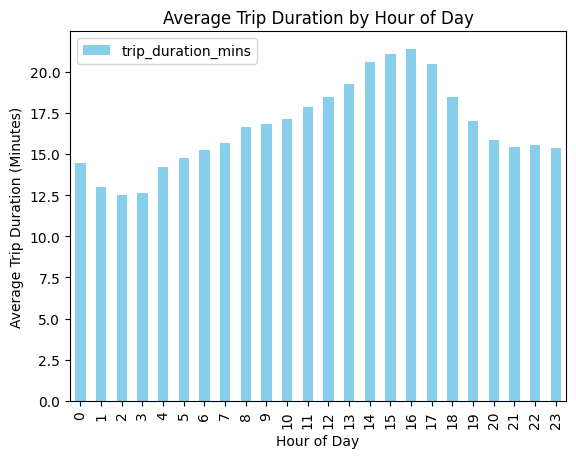

In [21]:
# Calculate and plot average trip duration by hour of the day
hourly_trip_duration = df.groupby('pickup_hour')['trip_duration_mins'].mean().reset_index()

hourly_trip_duration.plot(x='pickup_hour', y='trip_duration_mins', kind='bar', color='skyblue')
plt.title('Average Trip Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (Minutes)')

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'triplength_hourofday.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Midday and Afternoon Peaks**:
   - The chart shows that average trip durations increase steadily throughout the morning, peaking between 3 PM and 5 PM.
   - This could be due to heavier traffic during the afternoon rush, which might result in longer travel times, particularly when tourists are moving between attractions or returning to their accommodations.

2. **Early Morning Efficiency**:
   - Trip durations are shortest in the early morning hours (00:00 to 5:00), likely due to reduced traffic.
   - Tourists who are early risers or who have early flights may benefit from quicker travel times and less congestion during these hours.

3. **Evening and Night**:
   - After 18:00, trip durations begin to decrease, stabilizing around 12-15 minutes in the evening and late at night.
   - This suggests that while traffic might still be present, it eases after the evening rush, making travel more predictable.

### Key Insights
- **Avoid Peak Traffic**: To reduce time spent in transit, avoid traveling between 15:00 and 17:00, when trips are longest.
- **Take Advantage of Off-Peak Times**: Early morning and evening are optimal for quick, hassle-free travel, especially when moving between accommodations and attractions.
- **Plan Accordingly**: Knowing when travel times are shortest can help tourists better plan their day, ensuring more time for sightseeing and less time in transit.

## Trip Density by Time of Day and Day of the Week

We use a heatmap to show the density of trips across different times of day and days of the week, helping to identify peak periods for taxi rides.

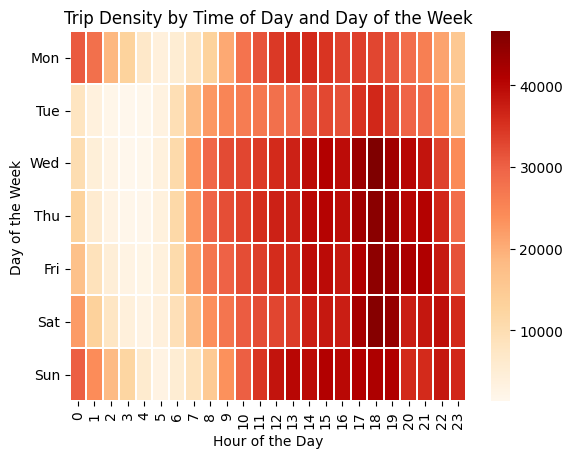

In [22]:
# Calculate and plot trip density by hour of the day and day of the week
pickup_density = df.groupby(['pickup_dayofweek', 'pickup_hour']).size().unstack()

sns.heatmap(pickup_density, cmap='OrRd', annot=False, fmt='d', linewidths=0.1)

plt.title("Trip Density by Time of Day and Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'tripdensity_hourday.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Weekday vs. Weekend Trends**:
   - The heatmap shows higher trip densities during weekdays, especially from Wednesday to Saturday.
   - This indicates that weekdays, particularly mid-week, are busier for taxis, likely due to the combination of commuter traffic and regular city activities.

2. **Peak Hours**:
   - The highest trip densities are observed between 4 PM and 8 PM on weekdays. This is consistent with rush hour traffic when people are leaving work.
   - Tourists should be aware that these times might result in longer wait times for taxis or higher fares due to increased demand.

3. **Morning Activity**:
   - There is a noticeable increase in trip density starting around 7:00 AM and continuing through the morning, peaking before noon.
   - This period is likely when people are commuting to work or school, and tourists might find it more difficult to get a taxi quickly during these hours.

4. **Late Night**:
   - Across all days, the density drops significantly after midnight, reaching its lowest point in the early morning hours (2:00 AM to 5:00 AM).
   - This could be the best time for tourists looking for late-night activities to find a taxi without much competition.

## Average Fare by Time of Day and Day of the Week

This heatmap visualizes how the average fare amount varies by the time of day and the day of the week, which can help in identifying pricing patterns.

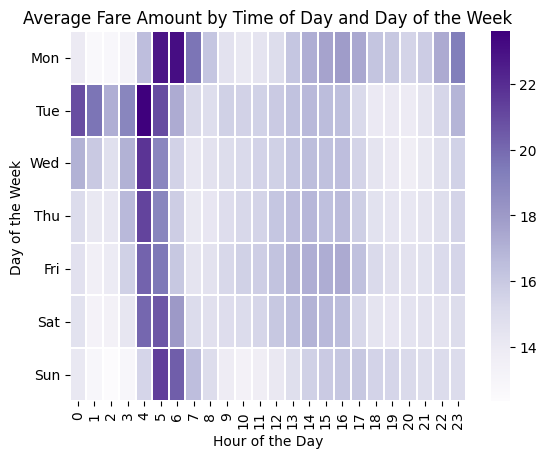

In [23]:
# Calculate and plot average fare by hour of the day and day of the week
fare_amount_density = df.groupby(['pickup_dayofweek', 'pickup_hour'])['fare_amount'].mean().unstack()

sns.heatmap(fare_amount_density, cmap='Purples', annot=False, fmt='.1f', linewidths=0.1)

plt.title("Average Fare Amount by Time of Day and Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'meanfare_hourday.png'), dpi=300, bbox_inches='tight')
plt.show()

1. **Early Morning**:
   - The heatmap reveals that the highest average fares occur early in the morning, particularly between 4:00 AM and 7:00 AM on weekdays, with a notable peak on Tuesday.
   - This might be due to low taxi availability in the early morning, increased demand or traffic from business travelers heading to early flights or commuters using taxis to reach work, driving up prices during these hours.

2. **Weekday Fare Patterns**:
   - After the early morning peak, average fares gradually decrease as the day progresses, stabilizing during the midday and evening hours.
   - Tourists might find that traveling during the middle of the day or late in the evening could offer more consistent and lower fare amounts.

3. **Notable Off-Peak Advantage**:
   - The consistent pattern across both weekdays and weekends shows that fares are lower during off-peak hours (midday and late evening). Tourists who plan their travel around these times can likely avoid higher fare rates.

## Geospatial Analysis: Average Fare by Location

We integrate the geographic data to visualize the average fare amount by pickup and drop-off locations on a map of NYC taxi zones.

In [24]:
# Load geographic data for taxi zones
merged_gdf = gpd.read_file("/Users/jennymai/Desktop/data_sci/mast_project1/data/raw_taxi_zones/merged_gdf.shp")
merged_gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,Borough_1,Zone_1,service_zo,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,EWR,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,Queens,Jamaica Bay,Boro Zone,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,Bronx,Allerton/Pelham Gardens,Boro Zone,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,Manhattan,Alphabet City,Yellow Zone,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,Staten Island,Arden Heights,Boro Zone,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,Bronx,Woodlawn/Wakefield,Boro Zone,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,Queens,Woodside,Boro Zone,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,Manhattan,World Trade Center,Yellow Zone,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,Manhattan,Yorkville East,Yellow Zone,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


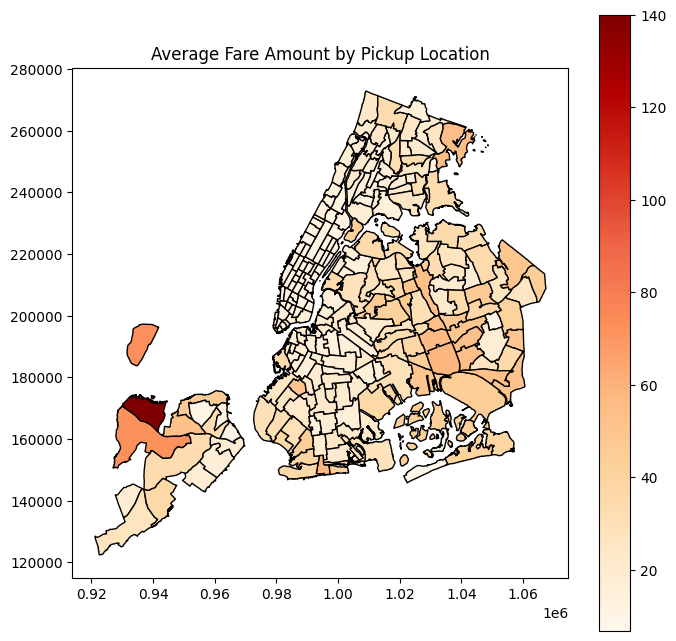

In [25]:
# Merge geographic data with taxi data on pickup location and plot the average fare by pickup location
pickup_merged = merged_gdf.merge(df, left_on='LocationID', right_on='PULocationID', how='inner')

pickup_grouped = pickup_merged.groupby('PULocationID').agg({'fare_amount': 'mean'}).reset_index()

pickup_merged_final = merged_gdf.merge(pickup_grouped, left_on='LocationID', right_on='PULocationID', how='inner')

fig, ax = plt.subplots(figsize=(8, 8))
pickup_merged_final.plot(column='fare_amount', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

plt.title("Average Fare Amount by Pickup Location")

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'meanfare_pickup.png'), dpi=300, bbox_inches='tight')
plt.show()

- **High-Fare Zones**: The darkest areas on the map, particularly in the western part of the city (likely Staten Island or certain high-cost areas), indicate the highest average fare amounts. These could be areas with longer trip distances, tolls, or premium services leading to higher fares.

- **Moderate-Fare Zones**: Areas with lighter shades of orange indicate moderate fare averages. These zones likely represent typical fares in more central locations with shorter trip distances or standard services.

- **Low-Fare Zones**: The lightest areas (Business districts, Times Square, and Brooklyn) show lower average fares, possibly indicating either frequent short trips or areas with less demand for premium taxi services.

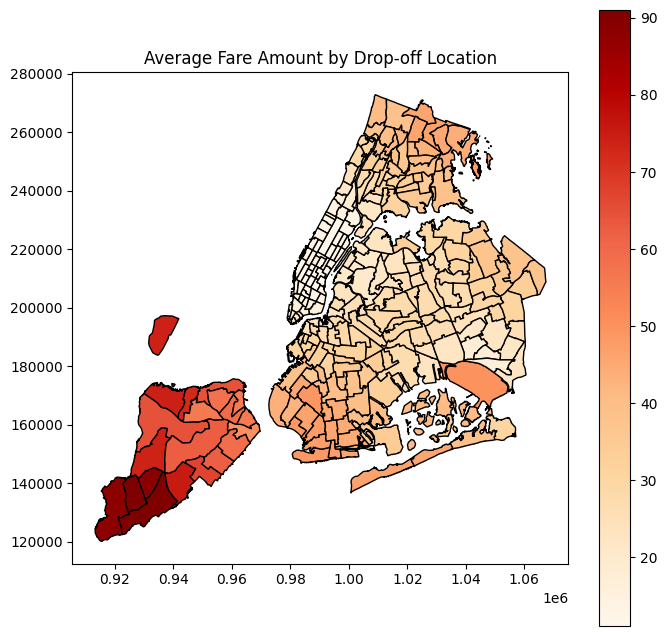

In [26]:
# Merge geographic data with taxi data on drop-off location and plot the average fare by drop-off location
dropoff_merged = merged_gdf.merge(df, left_on='LocationID', right_on='DOLocationID', how='inner')

dropoff_grouped = dropoff_merged.groupby('DOLocationID').agg({'fare_amount': 'mean'}).reset_index()

dropoff_merged_final = merged_gdf.merge(dropoff_grouped, left_on='LocationID', right_on='DOLocationID', how='inner')

fig, ax = plt.subplots(figsize=(8, 8))
dropoff_merged_final.plot(column='fare_amount', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

plt.title("Average Fare Amount by Drop-off Location")

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'meanfare_dropoff.png'), dpi=300, bbox_inches='tight')

plt.show()

- **High-Fare Drop-off Zones**: The darkest regions, primarily concentrated in the southwestern part of the city (likely Staten Island), show the highest average fare amounts. These areas likely correspond to longer trips, potentially involving tolls or higher demand pricing, leading to elevated fares.

- **Moderate-Fare Drop-off Zones**: Areas shaded in lighter orange represent moderate fare averages. These drop-off points may be in central or easily accessible locations where the fares are more standard, possibly due to shorter distances or routine trips to central NYC (Manhattan).

- **Low-Fare Drop-off Zones**: The lightest areas (around Business districts) indicate the lowest average fare amounts. These could be drop-off points for short trips or in areas where taxi services are less frequently utilized or less costly.

## Geospatial Analysis: Trip Density by Location

This section visualizes the density of trips by pickup and drop-off locations to understand the spatial distribution of taxi demand.

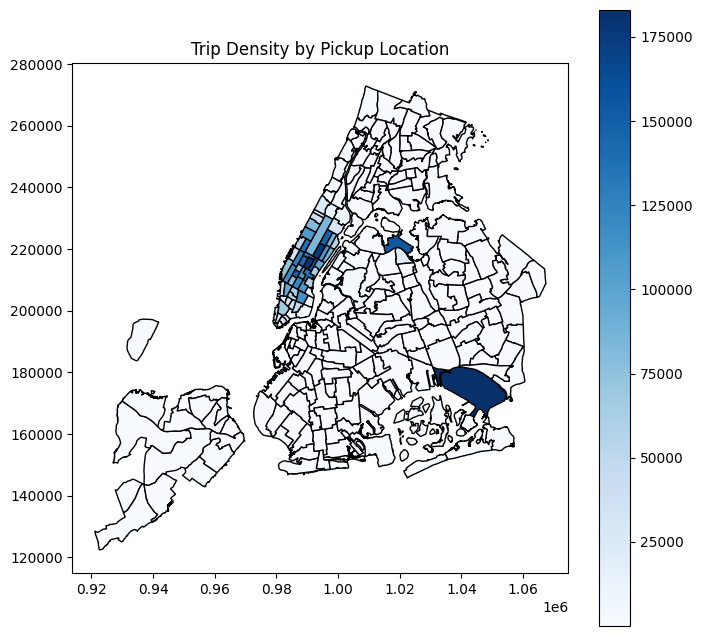

In [27]:
# Merge geographic data with taxi data on pickup location and plot the trip density by pickup location
pickup_merged = merged_gdf.merge(df, left_on='LocationID', right_on='PULocationID', how='inner')

pickup_grouped = pickup_merged.groupby('PULocationID').size().reset_index(name='trip_count')

pickup_merged_final = merged_gdf.merge(pickup_grouped, left_on='LocationID', right_on='PULocationID', how='inner')

fig, ax = plt.subplots(figsize=(8, 8))
pickup_merged_final.plot(column='trip_count', ax=ax, legend=True, cmap='Blues', edgecolor='black')

plt.title("Trip Density by Pickup Location")

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'tripdensity_pickup.png'), dpi=300, bbox_inches='tight')

plt.show()

=> Taxi pickups are most concentrated in central Manhattan, particularly around business districts and major transit hubs, reflecting high demand in these areas. Smaller but significant pickup densities are also seen at key locations like JFK Airport in Queens, highlighting these areas as major transit points for both locals and tourists. This map underscores Manhattan's central role in NYC's transportation network.

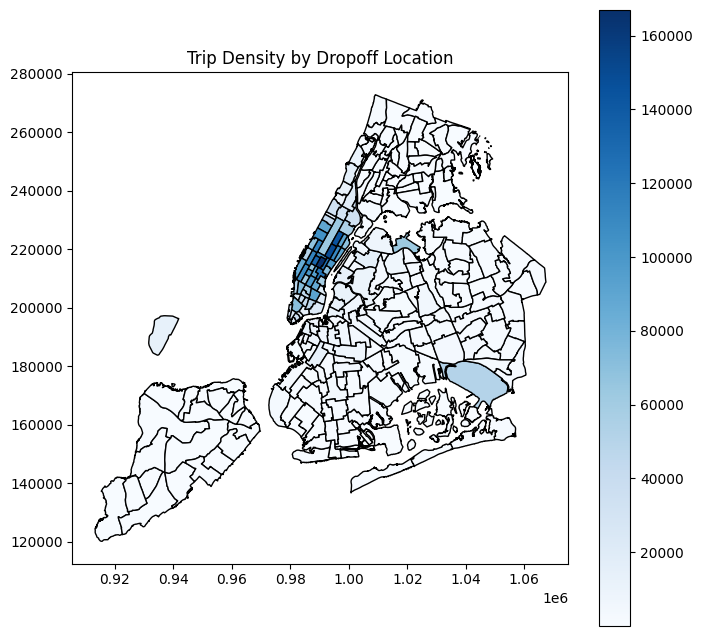

In [28]:
# Merge geographic data with taxi data on drop-off location and plot the trip density by drop-off location
dropoff_merged = merged_gdf.merge(df, left_on='LocationID', right_on='DOLocationID', how='inner')

dropoff_grouped = dropoff_merged.groupby('DOLocationID').size().reset_index(name='trip_count')

dropoff_merged_final = merged_gdf.merge(dropoff_grouped, left_on='LocationID', right_on='DOLocationID', how='inner')

fig, ax = plt.subplots(figsize=(8, 8))
dropoff_merged_final.plot(column='trip_count', ax=ax, legend=True, cmap='Blues', edgecolor='black')

plt.title("Trip Density by Dropoff Location")

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'tripdensity_dropoff.png'), dpi=300, bbox_inches='tight')

plt.show()

The map indicates that the highest trip densities are concentrated in Midtown Manhattan and JFK Airport, reflecting its status as a major destination for business, tourism, and transit.

## Peak Pickup Hours by Location

We identify and visualize the peak pickup hours for each location to understand when each location is busiest.

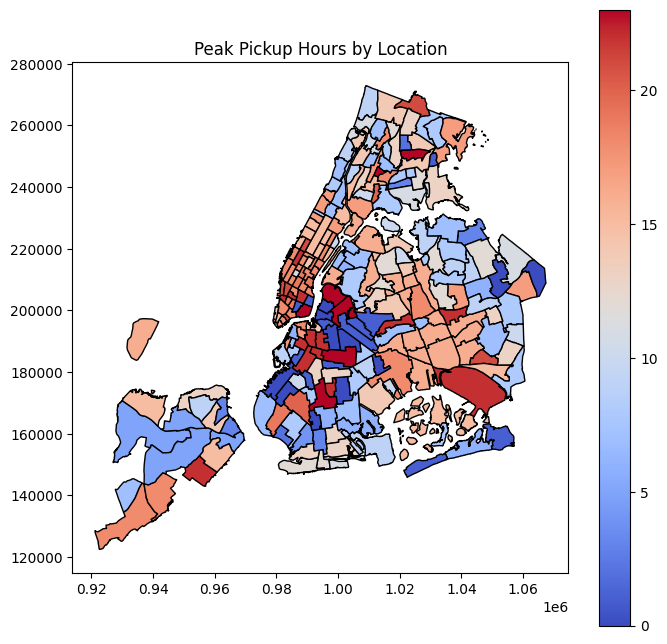

In [29]:
# Group by location and pickup hour to find the peak hour for each location
pickup_hour_grouped = pickup_merged.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='trip_count')

peak_hours = pickup_hour_grouped.loc[pickup_hour_grouped.groupby('PULocationID')['trip_count'].idxmax()]

peak_hours_merged_final = merged_gdf.merge(peak_hours, left_on='LocationID', right_on='PULocationID', how='inner')

fig, ax = plt.subplots(figsize=(8, 8))
peak_hours_merged_final.plot(column='pickup_hour', ax=ax, legend=True, cmap='coolwarm', edgecolor='black')

plt.title("Peak Pickup Hours by Location")

# Save the plot to the 'plots' directory
plt.savefig(os.path.join(output_dir, 'peakpickup.png'), dpi=300, bbox_inches='tight')

plt.show()

=> Manhattan's business districts experience peak pickups from 3 PM to midnight, coinciding with work commutes and evening events.

In contrast, Brooklyn's nightlife areas, such as Williamsburg, see peaks between 10 PM and 3 AM.

In [30]:
# Stop the Spark session to release resources
spark.stop()